In [4]:
from pathlib import Path
import re
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

# ====== RUTAS (MISMA FECHA) ======
lum_dir = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\LUM_outputs_20251210")

# Salida (GeoTIFF masked + PNGs)
out_tif_dir = lum_dir.parent / "LUM_masked_20251210"
out_png_dir = lum_dir.parent / "LUM_masked_png_20251210"
out_tif_dir.mkdir(parents=True, exist_ok=True)
out_png_dir.mkdir(parents=True, exist_ok=True)

# Bandas en RL: 0:B,1:G,2:R,3:RE,4:NIR
NIR_IDX = 4

def parse_plot_id(name: str) -> int:
    m = re.search(r"plot_(\d+)_LUM_RL\.tif$", name)
    return int(m.group(1)) if m else None

def save_png(nir, mask, out_path, title):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(nir, cmap="RdYlGn")
    plt.title(title)
    plt.axis("off")
    plt.colorbar(shrink=0.7)

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Soil mask (NIR < Otsu)")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=250, bbox_inches="tight")
    plt.close()

print("lum_dir:", lum_dir)
print("out_tif_dir:", out_tif_dir)
print("out_png_dir:", out_png_dir)


lum_dir: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\LUM_outputs_20251210
out_tif_dir: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\LUM_masked_20251210
out_png_dir: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\LUM_masked_png_20251210


In [5]:
rl_files = sorted(lum_dir.glob("plot_*_LUM_RL.tif"))
print("LUM RL encontrados:", len(rl_files))

ok, fail = 0, 0

for rl_path in rl_files:
    plot_id = parse_plot_id(rl_path.name)
    plot_name = f"plot_{plot_id}"

    try:
        with rasterio.open(rl_path) as src:
            RL = src.read().astype(np.float32)  # (5,H,W)
            profile = src.profile.copy()

        nir = RL[NIR_IDX]

        # máscara válida para calcular otsu (evita NaNs)
        valid = np.isfinite(nir)
        if valid.sum() < 50:
            print(f"[SKIP] {plot_name}: muy pocos píxeles válidos en NIR")
            fail += 1
            continue

        # Otsu sobre NIR
        t = float(threshold_otsu(nir[valid]))

        # Soil mask: NIR bajo
        soil_mask = (nir < t) & valid

        # Enmascarar suelo con NaN (mantener canopy)
        RL_masked = RL.copy()
        RL_masked[:, soil_mask] = np.nan

        # Guardar GeoTIFF enmascarado
        out_tif = out_tif_dir / f"{plot_name}_LUM_RL_masked.tif"
        prof_out = profile.copy()
        prof_out.update(count=5, dtype="float32", nodata=None)

        with rasterio.open(out_tif, "w", **prof_out) as dst:
            dst.write(RL_masked.astype(np.float32))

        # Guardar PNG rápido (opcional pero útil)
        out_png = out_png_dir / f"{plot_name}_nir_mask.png"
        save_png(nir, soil_mask, out_png, f"{plot_name} NIR (Otsu={t:.4f})")

        print(f"[OK] {plot_name} -> masked tif + png | Otsu={t:.4f} | soil pixels={int(soil_mask.sum())}")
        ok += 1

    except Exception as e:
        print(f"[FAIL] {plot_name}: {e}")
        fail += 1

print("\n✅ Terminado Paso 7")
print("OK:", ok, "| FAIL:", fail)
print("Salida masked tif:", out_tif_dir)
print("Salida png:", out_png_dir)


LUM RL encontrados: 202
[OK] plot_100 -> masked tif + png | Otsu=0.0000 | soil pixels=31419
[OK] plot_101 -> masked tif + png | Otsu=0.0000 | soil pixels=36607
[OK] plot_102 -> masked tif + png | Otsu=0.0000 | soil pixels=37541
[OK] plot_103 -> masked tif + png | Otsu=0.4453 | soil pixels=37602
[OK] plot_104 -> masked tif + png | Otsu=0.0001 | soil pixels=40720
[OK] plot_105 -> masked tif + png | Otsu=0.0000 | soil pixels=29368
[OK] plot_106 -> masked tif + png | Otsu=0.0001 | soil pixels=41056
[OK] plot_107 -> masked tif + png | Otsu=0.0001 | soil pixels=40284
[OK] plot_108 -> masked tif + png | Otsu=0.0001 | soil pixels=32491
[OK] plot_109 -> masked tif + png | Otsu=0.0001 | soil pixels=39588
[OK] plot_10 -> masked tif + png | Otsu=0.0001 | soil pixels=38435
[OK] plot_110 -> masked tif + png | Otsu=0.0001 | soil pixels=37232
[OK] plot_111 -> masked tif + png | Otsu=0.4018 | soil pixels=38989
[OK] plot_112 -> masked tif + png | Otsu=0.4236 | soil pixels=37018
[OK] plot_113 -> masked t

Mostrando: plot_100_LUM_RL_masked.tif


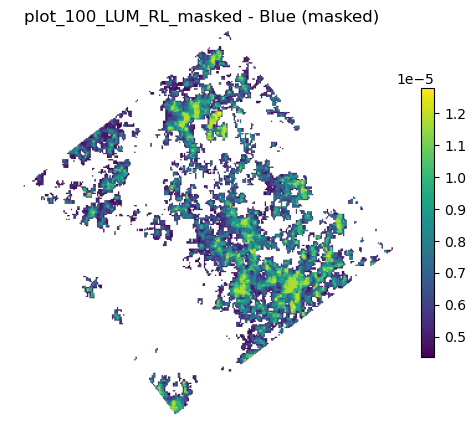

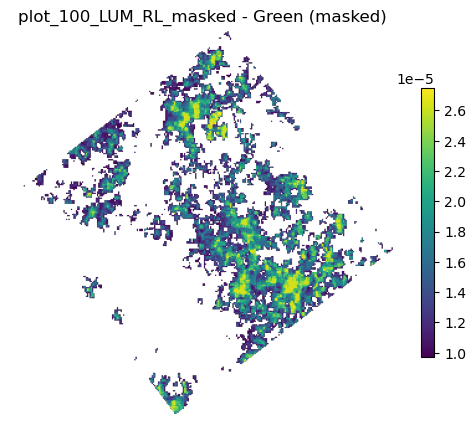

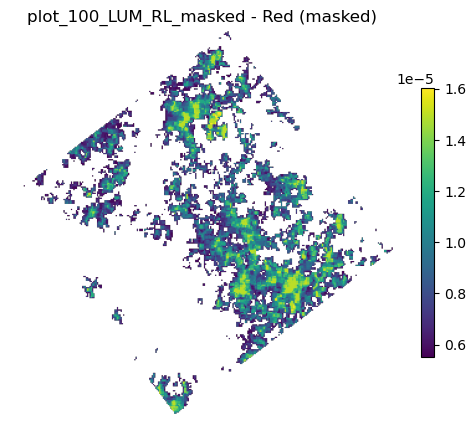

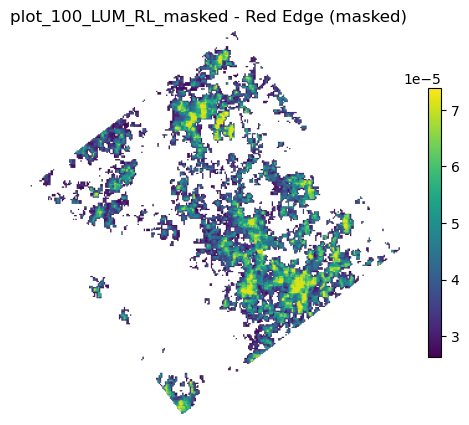

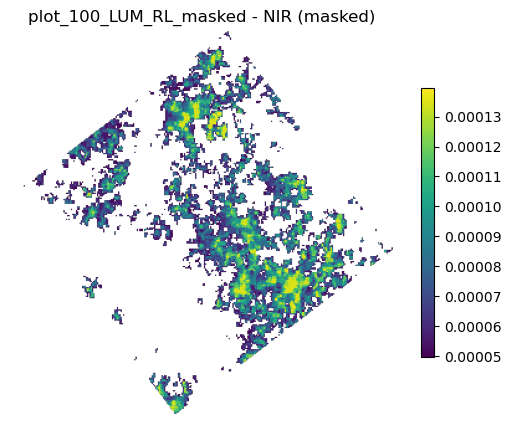

In [6]:
import rasterio
import matplotlib.pyplot as plt

masked_files = sorted(out_tif_dir.glob("plot_*_LUM_RL_masked.tif"))
if len(masked_files) == 0:
    raise FileNotFoundError(f"No hay masked tifs en {out_tif_dir}. Corre la celda 2.")

test_masked = masked_files[0]
print("Mostrando:", test_masked.name)

with rasterio.open(test_masked) as src:
    RLm = src.read()  # (5,H,W)

band_titles = ['Blue', 'Green', 'Red', 'Red Edge', 'NIR']
for i, bname in enumerate(band_titles):
    plt.figure(figsize=(7,5))
    plt.imshow(RLm[i], cmap="viridis")
    plt.colorbar(shrink=0.7)
    plt.title(f"{test_masked.stem} - {bname} (masked)")
    plt.axis("off")
    plt.show()
